<a href="https://www.kaggle.com/code/yaramahrous/cnn-fake-real-faces?scriptVersionId=199236846" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io


import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D,Input
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model

In [2]:
root = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'

train_dir = root + 'train'
val_dir = root + 'valid'
test_dir = root + 'test'

In [3]:
def show_images(images,title,axis_titles=None):
    n_ims = len(images)
    if axis_titles is None: axis_titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    plt.title(title)
    n = 1
    for image,axis_title in zip(images,axis_titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(axis_title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

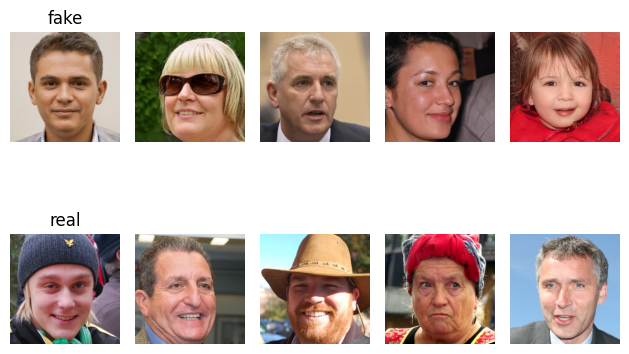

In [4]:
class_names = ['fake', 'real']
num_images = 5

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)
    
    # Plot title for the class
    plt.subplot(len(class_names), num_images, i * num_images + 1)
    plt.title(class_name)
    plt.axis('off')
    
    # Plot sample images
    for j in range(num_images):
        img_path = os.path.join(class_dir, images[j])
        img = io.imread(img_path)
        plt.subplot(len(class_names), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')

plt.tight_layout()
plt.show()
    


In [7]:
data_gen = ImageDataGenerator(rescale=1.0/255)
target_size = (128, 128)
batch_size = 32

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
)

val_generator = data_gen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
)


test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)


Found 100000 images belonging to 2 classes.

Found 20000 images belonging to 2 classes.

Found 20000 images belonging to 2 classes.


In [8]:
print("Training class distribution:", train_generator.class_indices)
print("Validation class distribution:", val_generator.class_indices)

Training class distribution: {'fake': 0, 'real': 1}

Validation class distribution: {'fake': 0, 'real': 1}


In [27]:
model = Sequential([
    Input(shape=(30,30,3)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid') 
])


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,833 (878.25 KB)

 Trainable params: 224,833 (878.25 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
history = model.fit(train_generator,validation_data=val_generator,epochs=10,verbose=2)

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

  warnings.warn(


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

  self._warn_if_super_not_called()


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 687s 219ms/step - accuracy: 0.6676 - loss: 0.8459 - val_accuracy: 0.7599 - val_loss: 0.5044

Epoch 2/10

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 219s 70ms/step - accuracy: 0.7607 - loss: 0.4965 - val_accuracy: 0.7495 - val_loss: 0.5103

Epoch 3/10

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 206s 66ms/step - accuracy: 0.7928 - loss: 0.4458 - val_accuracy: 0.8019 - val_loss: 0.4274

Epoch 4/10

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 207s 66ms/step - accuracy: 0.8189 - loss: 0.4063 - val_accuracy: 0.8077 - val_loss: 0.4263

Epoch 5/10

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 207s 66ms/step - accuracy: 0.8317 - loss: 0.3767 - val_accuracy: 0.8231 - val_loss: 0.4004

Epoch 6/10

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 204s 65ms/step - accuracy: 0.8454 - loss: 0.3543 - val_accuracy: 0.8371 - val_loss: 0.3720

Epoch 7/10

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 208s 66ms/step - accuracy: 0.8596 - loss: 0.3307 - val_accuracy: 0.8045 - val_loss: 0.4237

Epoch 8/10

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 206s 66ms/step - accura

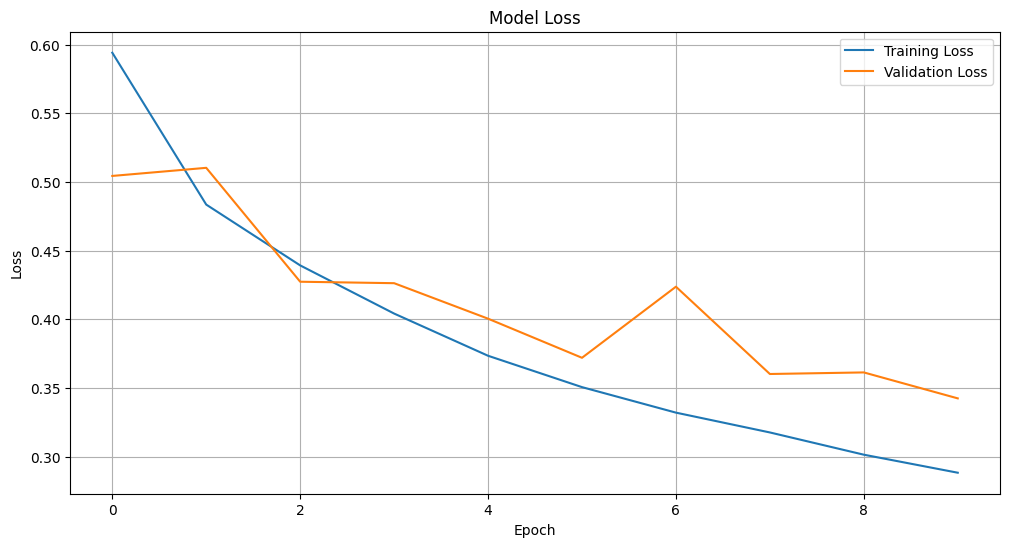

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

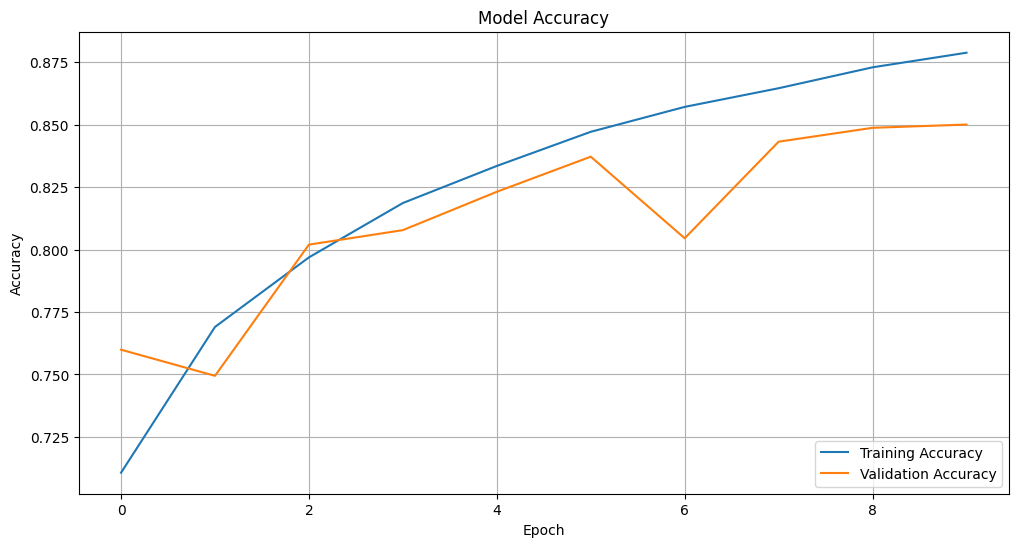

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [32]:
model2 = Sequential([
    Input(shape=(30,30,3)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(125, activation='relu'),
    Dense(64, activation='relu'),    
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') 
])

model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 125)            │        64,125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,062 (656.49 KB)

 Trainable params: 168,062 (656.49 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [34]:
history = model2.fit(train_generator,validation_data=val_generator,epochs=10,verbose=2)

Epoch 1/10

3125/3125 - 202s - 65ms/step - accuracy: 0.7386 - loss: 0.5283 - val_accuracy: 0.7845 - val_loss: 0.4601

Epoch 2/10

3125/3125 - 203s - 65ms/step - accuracy: 0.8098 - loss: 0.4192 - val_accuracy: 0.8185 - val_loss: 0.4032

Epoch 3/10

3125/3125 - 203s - 65ms/step - accuracy: 0.8383 - loss: 0.3661 - val_accuracy: 0.8378 - val_loss: 0.3665

Epoch 4/10

3125/3125 - 201s - 64ms/step - accuracy: 0.8577 - loss: 0.3286 - val_accuracy: 0.8518 - val_loss: 0.3416

Epoch 5/10

3125/3125 - 207s - 66ms/step - accuracy: 0.8724 - loss: 0.2997 - val_accuracy: 0.8470 - val_loss: 0.3586

Epoch 6/10

3125/3125 - 204s - 65ms/step - accuracy: 0.8932 - loss: 0.2548 - val_accuracy: 0.8732 - val_loss: 0.3037

Epoch 8/10

3125/3125 - 205s - 65ms/step - accuracy: 0.9031 - loss: 0.2337 - val_accuracy: 0.8701 - val_loss: 0.3045

Epoch 9/10

3125/3125 - 204s - 65ms/step - accuracy: 0.9097 - loss: 0.2180 - val_accuracy: 0.8751 - val_loss: 0.3030

Epoch 10/10

3125/3125 - 208s - 67ms/step - accuracy: 0.

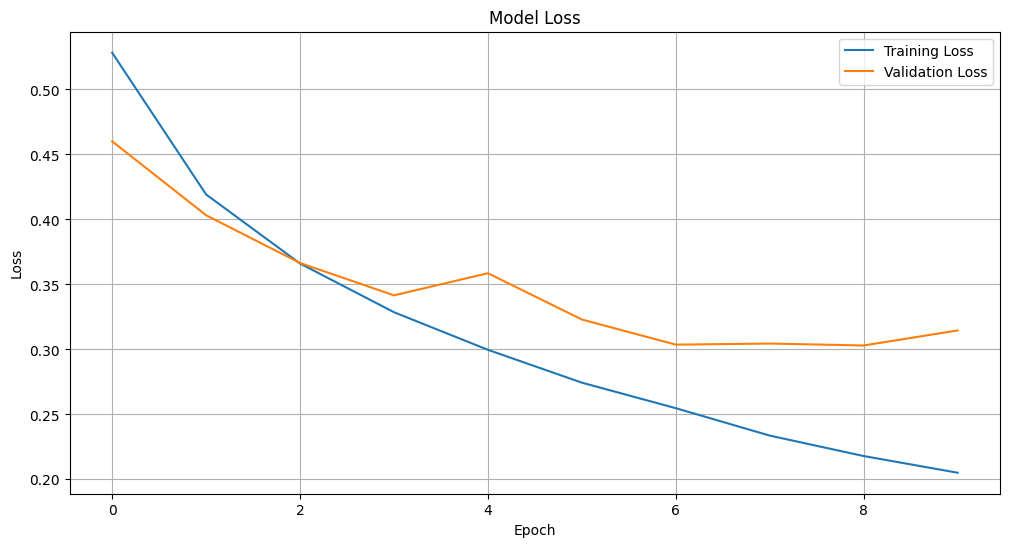

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

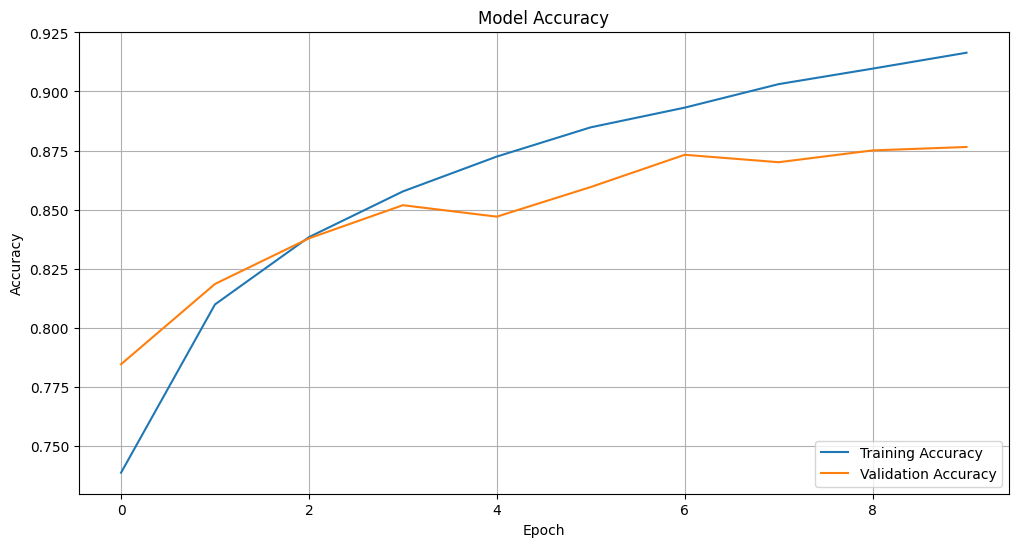

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [17]:
model3 = Sequential([
    Input(shape=(128,128,1)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(125, activation='relu'),
    Dense(64, activation='relu'),    
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') 
])

model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 125)            │     3,136,125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,238,974 (12.36 MB)

 Trainable params: 3,238,974 (12.36 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model3.fit(train_generator,validation_data=val_generator,epochs=10,verbose=2)

Epoch 1/10

3125/3125 - 1651s - 528ms/step - accuracy: 0.8402 - loss: 0.3591 - val_accuracy: 0.8928 - val_loss: 0.2542

Epoch 2/10

3125/3125 - 1555s - 498ms/step - accuracy: 0.9130 - loss: 0.2124 - val_accuracy: 0.9169 - val_loss: 0.2017

Epoch 3/10

3125/3125 - 1567s - 501ms/step - accuracy: 0.9447 - loss: 0.1421 - val_accuracy: 0.9258 - val_loss: 0.1861

Epoch 4/10

3125/3125 - 1556s - 498ms/step - accuracy: 0.9617 - loss: 0.0997 - val_accuracy: 0.9409 - val_loss: 0.1601

Epoch 5/10

3125/3125 - 1539s - 492ms/step - accuracy: 0.9706 - loss: 0.0774 - val_accuracy: 0.9394 - val_loss: 0.1697

Epoch 6/10

3125/3125 - 1588s - 508ms/step - accuracy: 0.9775 - loss: 0.0604 - val_accuracy: 0.9416 - val_loss: 0.1682

Epoch 7/10

3125/3125 - 1547s - 495ms/step - accuracy: 0.9818 - loss: 0.0484 - val_accuracy: 0.9298 - val_loss: 0.2427

Epoch 8/10

3125/3125 - 1575s - 504ms/step - accuracy: 0.9848 - loss: 0.0406 - val_accuracy: 0.9454 - val_loss: 0.1787

Epoch 9/10

3125/3125 - 1538s - 492ms/st

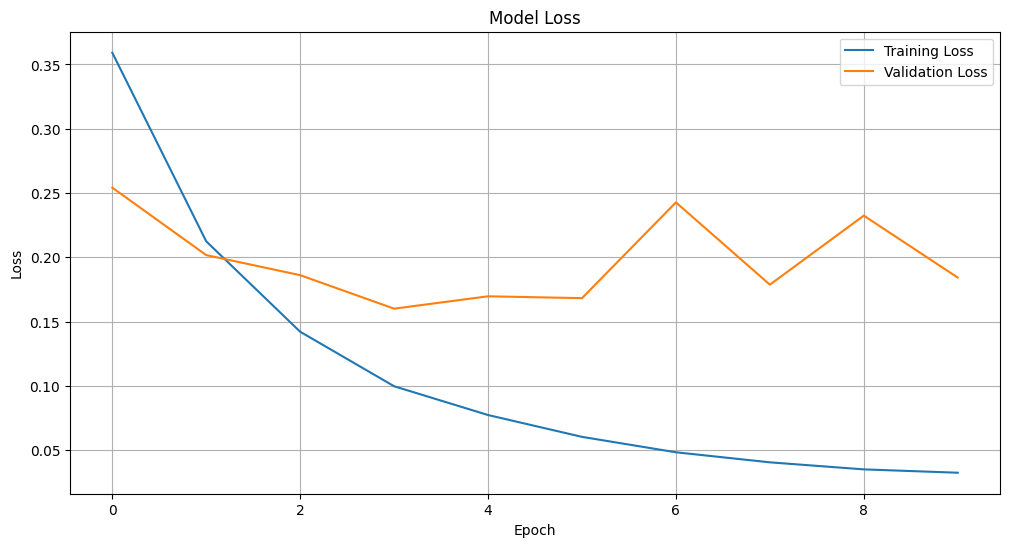

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

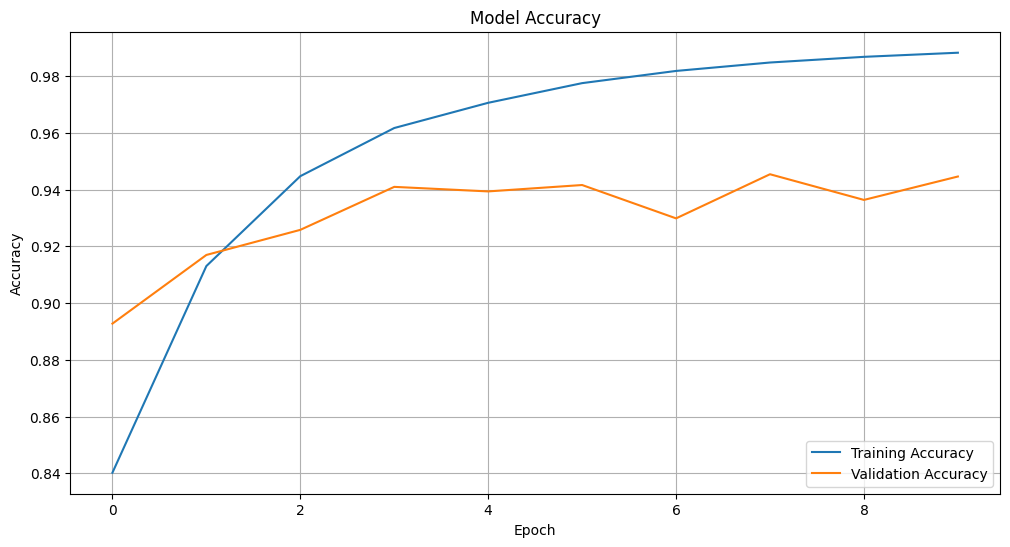

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [25]:
predictions = model3.predict(test_generator, verbose=1)

predicted_percentages = predictions * 100
predicted_classes = np.where(predicted_percentages > 50, 1, 0)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

625/625 ━━━━━━━━━━━━━━━━━━━━ 176s 281ms/step

              precision    recall  f1-score   support



        fake       0.96      0.94      0.95     10000

        real       0.94      0.96      0.95     10000



    accuracy                           0.95     20000

   macro avg       0.95      0.95      0.95     20000

weighted avg       0.95      0.95      0.95     20000




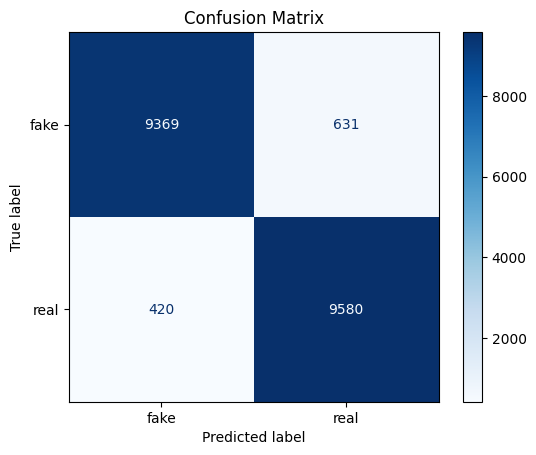

In [26]:
cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [29]:
model3.save('/kaggle/working/model3.keras')

In [ ]:
newload